# Observation Planning

In case you want to plan future observations, multiple clever strategies can be used. Here, I will demonstrate

1. Case of SNU Pyeongchang Campus telescope (60-cm, using limiting mag of V=14.5 for polarimeter)
    * Focusing on asteroids, not comets
    * Focusing on MBAs, not NEAs.
2. First, only ~1% of known asteroids can be "bright enough"
    * "maximum possible" brightness can be obtained by assuming r_hel=q, r_obs=MOID, and α=0.
3. For the selected 1% of objects (say ``useful`` objects), calculate their r_hel, r_obs, and alpha.
    * This does not have to be accurate. Use simple approximations in N-body.
    * Timestep for the calculations is 1 day for the next 60 days.
4. Then choose objects that can be bright enough for that time interval (60d)
    * "maximum possible" brightness can be obtained by assuming r_hel=min(r_hel), r_obs=min(r_obs), and α=min(α) during that interval.
5. Only ~10^3 objects (say ``vmag_cut`` objects) will be chosen. For them, do "accurate" calculations.
    * Use Cone FOV with 150° radius, i.e., select solar-elongation > 30° objects only.

In [1]:
from pathlib import Path

import kete
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt

import skyloc as sloc

%config InlineBackend.figure_format = 'retina'
# %matplotlib notebook
InteractiveShell.ast_node_interactivity = 'last_expr'

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

observatory = (37.53660, 128.444790, 0.3)  # lat, lon in deg, height in km
VMAG_CUT = 14.5

In [2]:
# Download the orbit information file from JPL SBDB
# ~ 4-10min for the first time, ~10s for subsequent runs.
orb, m_ng = sloc.fetch_orb(
    output="orb_sbdb.parq",
    update_output=999,  # days - if output's last-modified is older than this, it will be updated
    # filters=[
        # ("kind", "not in", ("au")),
        # ("kind", "in", ("cu", "cn")),
        # ("condition_code", "in", ["0", "1"]),
    # ]
)
print("Number of objects, number of columns: ", orb.shape)
print("latest 'soln_date' [US/Pacific]     : ", orb["soln_date"].max())

# Just for printing purposes...
n_ng = np.sum(m_ng)

print("Number of     grav objects          : ", orb.shape[0] - n_ng)
print("Number of non-grav objects          : ", n_ng)

Number of objects, number of columns:  (1449241, 36)
latest 'soln_date' [US/Pacific]     :  2025-06-09 07:42:01
Number of     grav objects          :  1448434
Number of non-grav objects          :  807


In [3]:
if "moid" not in orb.columns:
    sq = sloc.SBDBQuery(fields=["pdes", "moid"])
    df = sq.query()
    # fill moid column based on orb["desig"] and df["pdes"]
    orb = orb.merge(df[["pdes", "moid"]], left_on="desig", right_on="pdes", how="left")

# Assume phase=0, r_hel=q, r_obs=moid, H=H to get theoretical V-mag:
vmag = sloc.iau_hg_mag(hmag=orb["H"], rhel=orb["peri_dist"], robs=orb["moid"], alpha__deg=0)
vmask = (vmag < VMAG_CUT) & ~pd.isna(vmag)
orb_useful = orb.loc[vmask].copy().reset_index(drop=True)
print(len(orb_useful), f"objects with V-mag < {VMAG_CUT}")

14138 objects with V-mag < 14.5


In [7]:
# === 1. Crude calculation
times = Time("2025-12-01") + np.arange(0, 60, 1) * u.day
fovs_c = []
for _t in times:
    jd_tdb = _t.tdb.jd
    name = _t.strftime("%Y-%m-%d %H:%M:%S")
    obssta = kete.spice.earth_pos_to_ecliptic(
        jd_tdb, *observatory, name=name, center=399  # geocenter will be changed to Sun below
    )

    fovs_c.append(sloc.make_omni_fov(
        state_desig=name,
        jd_tdb=jd_tdb,
        pos_au=obssta.pos,
        vel_aupd=obssta.vel,
        vel_frame=None,  # if kete.Vector is provided, frame should be None
        pos_frame=None,
    )[1])

fovs_c = sloc.FOVCollection(fovs_c)

# --- 1.5M objs: ~15s on MBP 14" [2024, macOS 15.2, M4Pro(8P+4E/G20c/N16c/48G)]
# Initialize
sl_c = sloc.SSOLocator(fovs=fovs_c, orb=orb_useful, non_gravs=True)
#                                                   ^^^^^^^^^^^^^^^
# Automatically use non-gravitational accelerations if parameters are available

# N-body propagate to mean JD of FOVs
# (later N-body simulations will be done *from* this JD0)
sl_c.propagate_n_body(include_asteroids=False, jd0=times.tdb.jd[0])

# Check which FOVs contain which objects.
sl_c.fov_state_check(include_asteroids=False, dt_limit=5.)

fov_hasobj_c = sl_c.fovc_hasobj
orb_infov_c = sl_c.orb.loc[sl_c.orb_infov_mask].copy()

print(f"Number of FOVs with objects: {fov_hasobj_c.shape[0]} out of {len(fovs_c)}")
print(f"Number of objects in FOVs  : {orb_infov_c.shape[0]}")

Number of FOVs with objects: 60 out of 60
Number of objects in FOVs  : 14133


In [8]:
# --- Calculate brief geoemtry, cut by Vmag
eph_c = []
# a low-level function that is behind the "calc_ephems" method - ~100 times faster than the full calc_ephems
for simsta in sl_c.fov_check_simstates:
    eph_c.append(pd.DataFrame.from_dict(
        sloc.calc_geometries(simsta, do_hel_ecl=False, do_obs_ecl=False, do_radec=False)
    ))
eph_c = pd.concat(eph_c)

# Cut based on "theoretical maximum" brightness during the next timeinterval:
desig_vmag_cut = []
for desig, _eph in eph_c.groupby("desig"):
    alpha_min = _eph["alpha"].min()
    r_hel_min = _eph["r_hel"].min()
    r_obs_min = _eph["r_obs"].min()
    hmag = orb_useful.loc[orb_useful["desig"] == desig, "H"].values[0]
    vmag_theo = sloc.iau_hg_mag(hmag=hmag, rhel=r_hel_min, robs=r_obs_min, alpha__deg=alpha_min)
    if vmag_theo < VMAG_CUT:
        desig_vmag_cut.append(desig)

orb_vmag_cut = orb_useful.loc[orb_useful["desig"].isin(desig_vmag_cut)].copy().reset_index(drop=True)

Above took ~6.5s on MBP 14" [2024, macOS 15.2, M4Pro(8P+4E/G20c/N16c/48G)].

In [19]:
# === 2. Accurate calculation
times = Time("2025-12-01") + np.arange(0, 60, 0.5) * u.day
fovs_a = []
for _t in times:
    jd_tdb = _t.tdb.jd
    name = _t.strftime("%Y-%m-%d %H:%M:%S")
    obssta = kete.spice.earth_pos_to_ecliptic(
        jd_tdb, *observatory, name=name, center=399  # geocenter will be changed to Sun below
    )

    sunsta = kete.spice.get_state("10", jd_tdb, "399").as_equatorial

    # FoV at anti-sun, radius = 150 deg to include objects >~30deg from the sun.
    fovs_a.append(sloc.make_cone_fov(
        state_desig=name,
        jd_tdb=jd_tdb,
        pos_au=obssta.pos,
        vel_aupd=obssta.vel,
        center_ra_deg=(sunsta.pos.ra + 180) % 360,
        center_dec_deg=-sunsta.pos.dec,
        radius_deg=150,  # sufficiently large
        vel_frame=None,  # if kete.Vector is provided, frame should be None
        pos_frame=None,
    )[1])

fovs_a = sloc.FOVCollection(fovs_a)

# --- 1.5M objs: ~15s on MBP 14" [2024, macOS 15.2, M4Pro(8P+4E/G20c/N16c/48G)]
# Initialize
sl_a = sloc.SSOLocator(fovs=fovs_a, orb=orb_vmag_cut, non_gravs=True)
#                                                     ^^^^^^^^^^^^^^^
# Automatically use non-gravitational accelerations if parameters are available

# N-body propagate to mean JD of FOVs
# (later N-body simulations will be done *from* this JD0)
sl_a.propagate_n_body(include_asteroids=False, jd0=times.tdb.jd[0])

# Check which FOVs contain which objects.
sl_a.fov_state_check(include_asteroids=False, dt_limit=5.)

fov_hasobj_a = sl_a.fovc_hasobj
orb_infov_a = sl_a.orb.loc[sl_a.orb_infov_mask].copy()
sl_a.calc_ephems()

print(f"Number of FOVs with objects: {fov_hasobj_a.shape[0]} out of {len(fovs_a)}")
print(f"Number of objects in FOVs  : {orb_infov_a.shape[0]}")

Number of FOVs with objects: 120 out of 120
Number of objects in FOVs  : 684


Above took ~6.1s on MBP 14" [2024, macOS 15.2, M4Pro(8P+4E/G20c/N16c/48G)].

In [20]:
eph = sl_a.eph
eph["h_cul"] = 90 - observatory[0] + eph["dec"]
eph = eph.loc[eph["h_cul"] > 20].copy().reset_index(drop=True)  # only ~ 1% of objects are dropped
eph

,desig,alpha,r_hel,r_obs,ra,dec,hel_ecl_lon,hel_ecl_lat,obs_ecl_lon,obs_ecl_lat,dra*cosdec/dt,ddec/dt,sky_motion,sky_motion_pa,vmag,jd_tdb,jd_utc,obsid,h_cul
0,6,30.591627,1.937699,1.668502,345.643675,-20.801533,9.955319,-11.606290,338.654015,-13.510692,0.889299,0.403307,0.976478,65.605209,8.762712,2.461011e+06,2461010.5,2025-12-01 00:00:00,31.661867
1,471,11.773261,2.239566,1.318592,45.267421,3.884438,54.665623,-7.435610,43.963637,-12.695952,-0.462482,0.313431,0.558685,-55.873936,9.037139,2.461011e+06,2461010.5,2025-12-01 00:00:00,56.347838
2,40,16.330416,2.260206,1.414989,110.337068,21.922953,92.478559,-0.124846,108.808877,-0.198206,-0.253211,0.111352,0.276613,-66.262062,9.357402,2.461011e+06,2461010.5,2025-12-01 00:00:00,74.386353
3,7,25.775860,2.265378,2.084861,160.861262,2.722431,135.438825,-4.576729,161.303002,-4.973133,0.565570,-0.361452,0.671205,122.582352,9.484053,2.461011e+06,2461010.5,2025-12-01 00:00:00,55.185831
4,16,3.662202,2.662371,1.685582,76.796258,18.118830,74.189512,-3.003099,77.418098,-4.745616,-0.531814,-0.052229,0.534373,-95.609016,9.598274,2.461011e+06,2461010.5,2025-12-01 00:00:00,70.582230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73830,259221,19.867855,1.349780,0.397779,105.689939,33.049989,121.938186,3.028721,103.321294,10.333423,-2.369738,-1.591679,2.854663,-123.888023,18.179518,2.461070e+06,2461070.0,2026-01-29 12:00:00,85.513389
73831,66391,34.070251,0.984314,1.631542,275.770510,-25.155686,241.143171,-3.021241,275.224257,-1.820982,1.530806,0.593131,1.641698,68.820496,18.264025,2.461070e+06,2461070.0,2026-01-29 12:00:00,27.307714
73832,385402,50.613056,1.257261,0.959053,27.219147,12.697930,80.424037,1.055353,29.799691,1.385611,3.066925,-0.124944,3.069469,92.332901,18.515131,2.461070e+06,2461070.0,2026-01-29 12:00:00,65.161330
73833,220839,135.767593,0.777171,0.265528,276.518785,-17.802267,139.901892,1.872713,276.234163,5.496064,-0.735910,0.200064,0.762620,-74.791145,20.130507,2.461070e+06,2461070.0,2026-01-29 12:00:00,34.661133


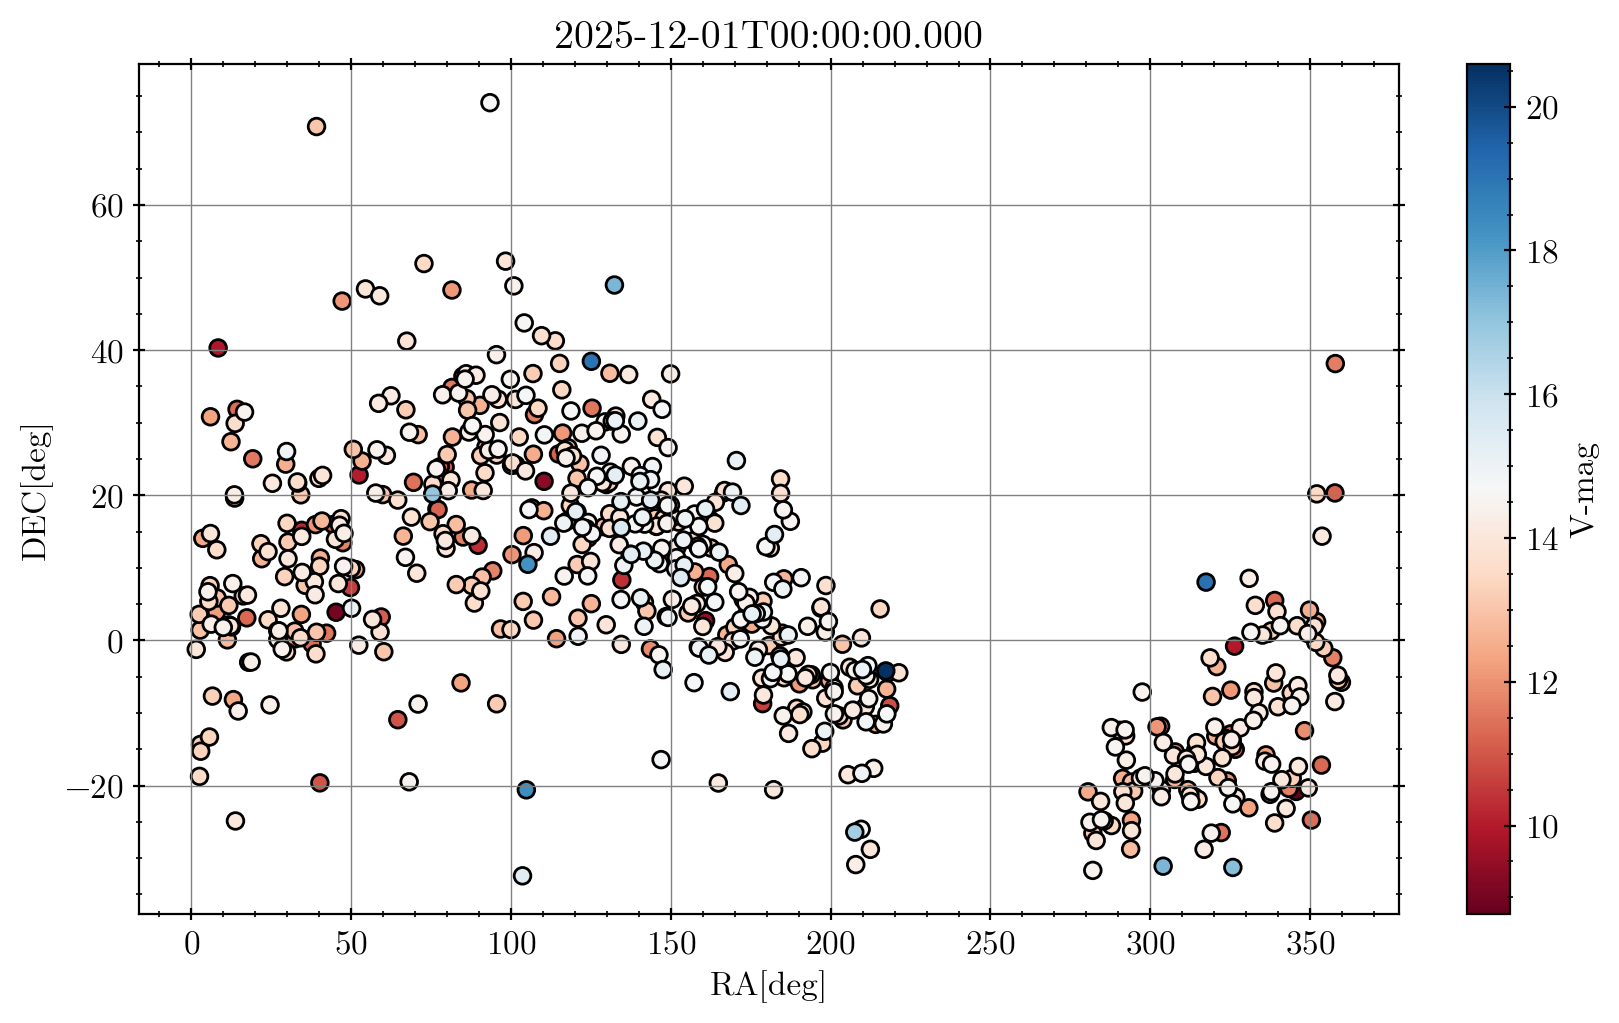

In [21]:
t0 = times[0].utc.isot
_eph = eph.loc[eph["jd_utc"] == times[0].utc.jd]
fig, axs = plt.subplots(1, 1, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)

sc = axs.scatter(_eph["ra"], _eph["dec"], c=_eph["vmag"], cmap="RdBu", edgecolors="k")
#colorbar:
cbar = plt.colorbar(sc, ax=axs)
cbar.set_label("V-mag")
axs.set(
    title=t0,
    xlabel="RA[deg]",
    ylabel="DEC[deg]"
)

plt.show();